In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [122]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=0.001, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
    
    def fit(self, X, y):
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        w = np.zeros(X.shape[1])
        for _ in range(self.n_iter):
            for i in range(X.shape[0]):
                w += self.eta * (y[i] - np.dot(w, X[i])) * X[i]
                self.mse_.append(mean_squared_error(y, np.dot(X, w.T)))
                self.weights_.append(np.copy(w))
        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self
    
    def predict(self, X):
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        return np.dot(X, self.w_.T)

In [123]:
data_demo = pd.read_csv("C:/Users/Ilsaf/Desktop/weights_heights.csv", index_col="Index")

In [124]:
data_demo.head(3)

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269


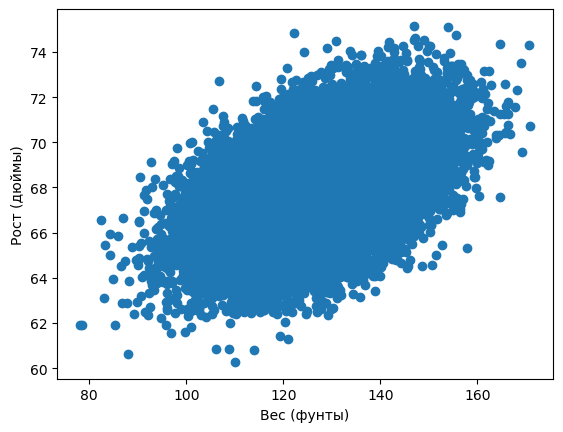

In [125]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Вес (фунты)")
plt.ylabel("Рост (дюймы)");

In [126]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

In [127]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [128]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

In [129]:
sgd = SGDRegressor()
sgd.fit(X_train_scaled, y_train)

SGDRegressor()

In [130]:
sgd.__dict__

{'eta': 0.001,
 'n_iter': 10,
 'mse_': [4616.852920655767,
  4608.3375526145255,
  4598.768933110513,
  4589.623842635082,
  4580.301228187296,
  4571.640079739266,
  4561.801172200144,
  4552.423952074522,
  4543.291313548409,
  4534.247381237228,
  4525.1795855814435,
  4515.579015460564,
  4507.060077824063,
  4497.6642671194095,
  4488.353520687662,
  4479.488541445518,
  4470.5238585418865,
  4461.940693269498,
  4453.16460417838,
  4444.200036030372,
  4435.243317789221,
  4425.8916005069495,
  4417.590983549627,
  4408.799940125173,
  4400.4683298597165,
  4391.86901973491,
  4383.111026116577,
  4373.837959907845,
  4364.345145438097,
  4356.270791417086,
  4347.72366968802,
  4338.747640892751,
  4330.455975088126,
  4321.550555258036,
  4313.963031535591,
  4304.915989451534,
  4296.302723684518,
  4288.01319014944,
  4279.40939258681,
  4270.287806297105,
  4261.454002522366,
  4252.848466987705,
  4244.478261013104,
  4236.611098954353,
  4228.662970039417,
  4220.089950204

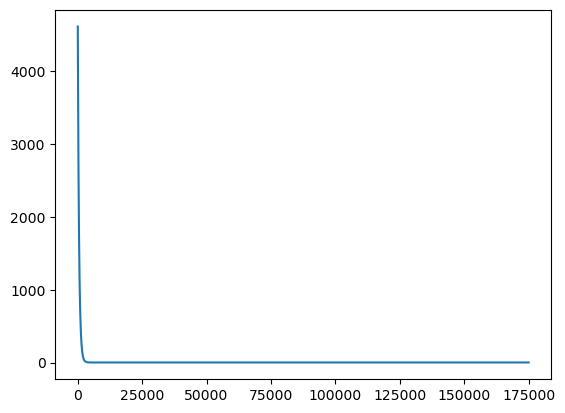

In [132]:
plt.plot(range(1, len(sgd.mse_)+1), sgd.mse_);

In [137]:
np.min(sgd.mse_), sgd.w_

(2.7151352406643623, array([67.9898497 ,  0.94447605]))

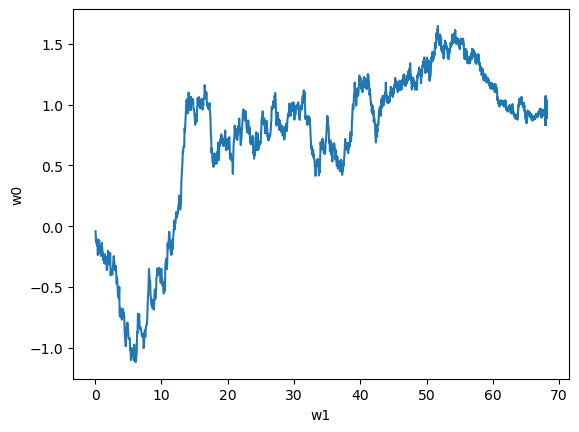

In [141]:
plt.plot(np.array(sgd.weights_)[:, 0], np.array(sgd.weights_)[:, 1]);
plt.xlabel("w1");
plt.ylabel("w0");

In [142]:
predict = sgd.predict(X_valid_scaled)

In [143]:
predict

array([66.25948329, 67.07341388, 67.26120079, ..., 68.50487872,
       67.5258781 , 67.84899701])

In [145]:
mean_squared_error(y_valid, predict)

2.6708681207033784

In [146]:
from sklearn.linear_model import LinearRegression

In [147]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [148]:
mean_squared_error(y_valid, lr.predict(X_valid_scaled))

2.670830767667635

In [465]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C, eta=0.001, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.C = C
        self.loss_ = []
        self.weights_ = []
    
    def sigma(self, z):
        z = z.flatten()
        z[z > 100] = 100
        z[z < -100] = -100
        return 1.0 / (1 + np.exp(-z))
    
    def log_loss(self, X, y, w):
        return np.sum([np.log(1 + np.exp(-y[i]*np.dot(w, X[i]))) for i in range(X.shape[0])])
    
    def fit(self, X, y):
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        w = np.zeros(X.shape[1])
        for _ in range(self.n_iter):
            for i in range(X.shape[0]):
                w += self.eta*(self.C * self.sigma(-y[i] * np.dot(w, X[i])) * y[i] * X[i] - np.array([0] + list(w[1:])))
                
                self.loss_.append(log_loss(y, self.sigma(X.dot(w))))
                self.weights_.append(w)
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
    
    def predict_proba(self, X):
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        return self.sigma( np.dot(X, self.w_.T) )
    
    def predict(self, X):
        return np.array([1 if p > 0.5 else -1 for p in self.predict_proba(X)])

In [466]:
from sklearn.datasets import load_breast_cancer

In [467]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

In [468]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [469]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [470]:
sgd = SGDClassifier(1, n_iter=3, eta=1e-3)
sgd.fit(X_train_scaled, y_train)

SGDClassifier(C=1, n_iter=3)

In [471]:
sgd.__dict__

{'eta': 0.001,
 'n_iter': 3,
 'C': 1,
 'loss_': [0.6938790170550867,
  0.6919461207380987,
  0.6901922137681693,
  0.6860098855261435,
  0.6804460444085731,
  0.6785400115581796,
  0.6756256721597742,
  0.6740758657215401,
  0.6728709432299056,
  0.6702368109401705,
  0.667310479764572,
  0.6669197505312103,
  0.6659092700220478,
  0.6662134126299389,
  0.664717687013094,
  0.6643417505578056,
  0.6577203563550107,
  0.6567145691335177,
  0.6542488916993002,
  0.6503844060198266,
  0.6490612086931293,
  0.6486438209085327,
  0.6481518684820378,
  0.6452832106396782,
  0.643939705510462,
  0.6414467182439368,
  0.641599798126016,
  0.6409931523469309,
  0.6391854654756894,
  0.6386465241895627,
  0.6366579926770445,
  0.635219763119056,
  0.6320995440314828,
  0.631027625741678,
  0.6298851510431075,
  0.6275288410737075,
  0.6275534965960224,
  0.6263875275093694,
  0.627323978255141,
  0.626339255190083,
  0.625936480796307,
  0.6241617658412759,
  0.6217650572272015,
  0.621001586237

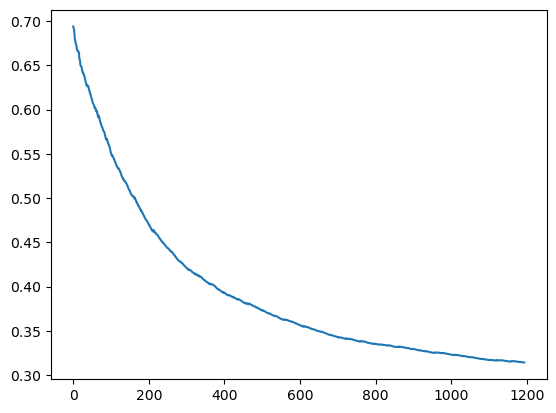

In [472]:
plt.plot(range(len(sgd.loss_)), sgd.loss_);

In [473]:
np.max(sgd.loss_)

0.6938790170550867

In [474]:
roc_auc_score(y_valid, sgd.predict_proba(X_valid_scaled))

0.9801788375558868

In [475]:
log_loss(y_valid, sgd.predict(X_valid_scaled))

2.1078159876676694

In [476]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, sgd.predict(X_valid_scaled))

0.9415204678362573

In [477]:
sgd2 = SGDClassifier(1000, n_iter=10)
sgd2.fit(X_train_scaled, y_train)

SGDClassifier(C=1000)

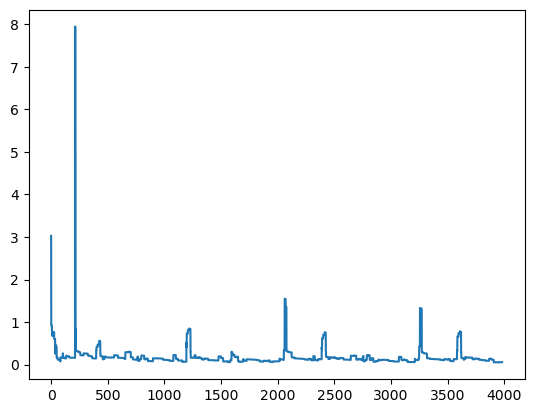

In [478]:
plt.plot(range(len(sgd2.loss_)), sgd2.loss_);

In [479]:
sgd2.__dict__

{'eta': 0.001,
 'n_iter': 10,
 'C': 1000,
 'loss_': [3.0265220469732212,
  0.9302849960705094,
  0.9297657304812448,
  0.929056168203482,
  0.9283271412785848,
  0.9276259909538104,
  0.8767540874368324,
  0.8760273088555219,
  0.695189620603165,
  0.6946203750017257,
  0.6940517286746355,
  0.6710728765020166,
  0.6705231292838965,
  0.7570569905395529,
  0.7564176182220693,
  0.7410739095610556,
  0.7404504588421592,
  0.7397869302544668,
  0.7391648377827461,
  0.738543404551651,
  0.7371845179692517,
  0.7246327243467067,
  0.7240431116085947,
  0.7234365789439032,
  0.72282809335554,
  0.7222228492814504,
  0.7632924875319462,
  0.6005322841641021,
  0.599957592036393,
  0.5994165916365986,
  0.5988430670288836,
  0.5982701552176922,
  0.597697834262397,
  0.5971261146500835,
  0.5965555752751774,
  0.5959850549082475,
  0.2568671209162744,
  0.25657988835019296,
  0.466025937598333,
  0.4655604914388081,
  0.44844210110943694,
  0.4479908518016701,
  0.4460712603256983,
  0.42844

In [480]:
sgd.w_

array([ 0.1150394 , -0.10567889, -0.07360741, -0.10722945, -0.10111613,
       -0.04387458, -0.07419414, -0.09720555, -0.11456287, -0.03948751,
        0.01509647, -0.07239635,  0.00681744, -0.06982129, -0.06702277,
        0.01914684, -0.02202813, -0.01456648, -0.04263819,  0.01486485,
        0.01453791, -0.11758403, -0.08491493, -0.11784667, -0.1077611 ,
       -0.06993637, -0.08756799, -0.10164763, -0.12086001, -0.07505301,
       -0.05015634])

In [481]:
sgd2.w_

array([ 3.71032423, -1.39170399, -2.39274523, -1.18152829, -1.4955829 ,
       -0.92414001,  1.61668251, -3.76765441, -3.74296675,  0.46659326,
        2.25855258, -4.59149344,  2.85235992, -2.62934734, -3.19758051,
        0.12949151,  4.19899079,  0.13653695,  0.22300048, -0.52013427,
        4.44066546, -2.72813855, -3.34174018, -1.48778068, -2.43182768,
       -2.61390133, -0.94994087, -5.18295616, -1.9678943 , -1.64676272,
       -2.56403726])

In [482]:
roc_auc_score(y_valid, sgd2.predict_proba(X_valid_scaled))

0.9800298062593145

In [483]:
log_loss(y_valid, sgd2.predict(X_valid_scaled))

1.264689592600602

In [484]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1)
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=1)

In [485]:
roc_auc_score(y_valid, lr.predict_proba(X_valid_scaled)[:, 1])

0.9885245901639343

In [486]:
log_loss(y_valid, lr.predict(X_valid_scaled))

0.8431263950670681

In [487]:
pd.DataFrame({"feature": cancer.feature_names, "importance": np.abs(sgd2.w_[1:])}).sort_values("importance", ascending=False)

,feature,importance
26,worst concavity,5.182956
10,radius error,4.591493
19,fractal dimension error,4.440665
15,compactness error,4.198991
6,mean concavity,3.767654
7,mean concave points,3.742967
21,worst texture,3.341740
13,area error,3.197581
11,texture error,2.852360
20,worst radius,2.728139


In [495]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
import re

In [496]:
df = pd.read_csv("C:/Users/Ilsaf/Desktop/Папка/Python/ML/vowpal_wabbit/IMDB Dataset.csv")

In [497]:
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})
#df["review"] = df["review"].apply(lambda doc: ' '.join(re.findall('\w{2,}', doc.lower())))

In [498]:
text_train, text_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.5, stratify=df["sentiment"], random_state=17)

In [499]:
text_train.shape

(25000,)

In [500]:
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

In [501]:
X_train.shape, X_test.shape

((25000, 1513060), (25000, 1513060))

In [502]:
%%time
lr = LogisticRegression(random_state=17)
lr.fit(X_train, y_train)

CPU times: total: 2min 49s
Wall time: 31.5 s


C:\Users\Ilsaf\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=17)

In [503]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.9611346496

In [507]:
%%time
sgd = SGDClassifier(random_state=17, loss="log_loss", max_iter=100)
sgd.fit(X_train, y_train)

CPU times: total: 2.59 s
Wall time: 1.76 s


SGDClassifier(loss='log_loss', max_iter=100, random_state=17)

In [508]:
sgd.n_iter_

17

In [509]:
roc_auc_score(y_test, sgd.predict_proba(X_test)[:, 1])

0.9584710111999999